# B-modes
*30 June 2020*

Numerically measuring the B-modes in our calculations.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from helpers import make_mask

## Small range

In [8]:
ext = 0.8 # half-width of image in arcsec
pixnum = 500
pixsize = 2*ext/pixnum

In [31]:
# recover alpha matrix from cannon output files
job_outs = ['cannon_out/myoutput_58385881.out']
linums = []
datalines = [None] * 500
for job_out in job_outs:
    with open(job_out, 'r') as f:
        for line in f:
            lin = line.split()
            if len(lin) > 4 and lin[0] == 'finished' and lin[1] == 'row':
                linum = int(lin[2])
                datalines[linum] = eval(' '.join(lin[3:]))
                linums.append(linum)
datalines = np.array(datalines)

In [3]:
datalines.shape

(500, 2, 500)

In [19]:
# import macro alphas (this step is not actually important for the curl)
macro_alphas = np.load('/n/home13/atsang/interlopers/files/alphas_macro_ext0.8_theta7.0.npy')
macro_alphas.shape

(2, 500, 500)

---

In [13]:
# difference between full and macro

In [14]:
alphamat_x = datalines[:,0,:] - macro_alphas[0]
alphamat_y = datalines[:,1,:] - macro_alphas[1]

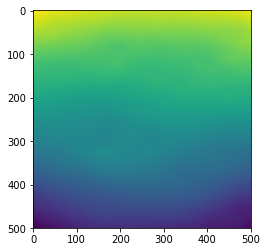

In [15]:
plt.imshow(alphamat_x)

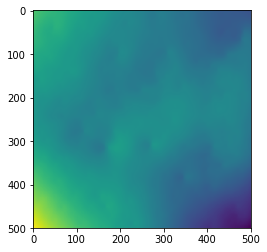

In [16]:
plt.imshow(alphamat_y)

---

In [12]:
def recalc_div_curl_5pt(alphamat_x, alphamat_y):
    ## Calculates divergence and curl using 5pt stencil, assuming alphamat_x, alphamat_y were already calculated.
    ## (adapted from helpers.py)
    divmat = np.zeros([pixnum-4,pixnum-4])
    curlmat = np.zeros([pixnum-4,pixnum-4])

    def divfunc(vec_x, vec_y,i,j):
        diffx = (-1./12.)*(vec_x[i][j+2] - vec_x[i][j-2])+(2./3.)*(vec_x[i][j+1] - vec_x[i][j-1])
        diffy = (-1./12.)*(vec_y[i+2][j] - vec_y[i-2][j])+(2./3.)*(vec_y[i+1][j] - vec_y[i-1][j])
        return (diffx + diffy)*(1./pixsize)

    def curlfunc(vec_x, vec_y,i,j):
        offy = (-1./12.)*(vec_y[i][j+2] - vec_y[i][j-2])+(2./3.)*(vec_y[i][j+1] - vec_y[i][j-1])
        offx = (-1./12.)*(vec_x[i+2][j] - vec_x[i-2][j])+(2./3.)*(vec_x[i+1][j] - vec_x[i-1][j])
        return (offy - offx)*(1./pixsize)

    for i in range(2,pixnum-2):
        for j in range(2,pixnum-2):
            divmat[i-2][j-2] = divfunc(alphamat_y,alphamat_x,i,j)
            curlmat[i-2][j-2] = curlfunc(alphamat_y,alphamat_x,i,j)

    return divmat, curlmat

In [43]:
divmat, curlmat = recalc_div_curl_5pt(alphamat_x, alphamat_y)

emodes = 0.5*divmat
bmodes = 0.5*curlmat

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\cdot \\vec\\alpha$')

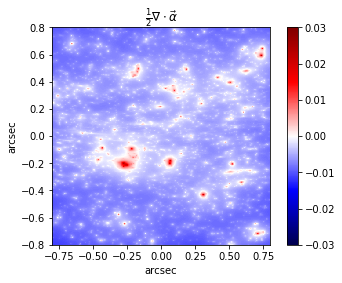

In [62]:
plt.imshow(emodes, extent=[-ext,ext,-ext,ext], vmin=-.03, vmax=.03, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\cdot \vec\alpha$')

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\times\\vec\\alpha$')

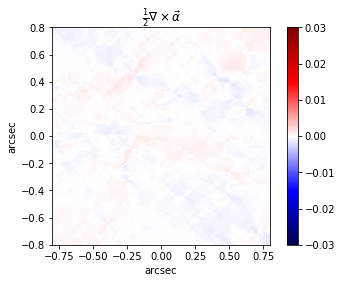

In [63]:
plt.imshow(bmodes, extent=[-ext,ext,-ext,ext], vmin=-.03, vmax=.03, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\times\vec\alpha$')

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\times\\vec\\alpha$')

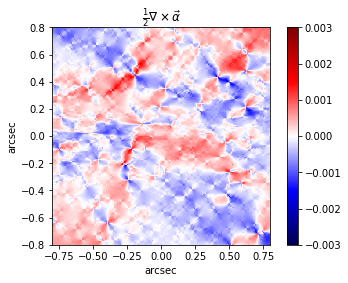

In [64]:
plt.imshow(bmodes, extent=[-ext,ext,-ext,ext], vmin=-.003, vmax=.003, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\times\vec\alpha$')

In [72]:
np.save('files/tmp_emodes.npy', emodes)
np.save('files/tmp_bmodes.npy', bmodes)

In [66]:
!~/python2 make_mask.py --pix_num=496 --side=10

In [67]:
!~/python2 power_spectrum.py \
--conv_file1 files/tmp_emodes.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name emodes \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/tmp_emodes.npy
k saved in files/kemodes_095_496_10.txt
saved files/ind_curves_emodes_095_496_10.npy


In [73]:
!~/python2 power_spectrum.py \
--conv_file1 files/tmp_bmodes.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name bmodes \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/tmp_bmodes.npy
k saved in files/kbmodes_095_496_10.txt
saved files/ind_curves_bmodes_095_496_10.npy


In [123]:
emodes_k = np.loadtxt('files/kemodes_095_496_10.txt')
bmodes_k = np.loadtxt('files/kbmodes_095_496_10.txt')
emodes_p = np.load('files/ind_curves_emodes_095_496_10.npy')[0]
bmodes_p = np.load('files/ind_curves_bmodes_095_496_10.npy')[0]

In [124]:
smallmax = 2*np.pi/(2/496*10.1) / 4 # Nyquist/stencil
smallmax

38.57004842031033

In [125]:
## Load theory curves
ps_subhalos = np.array([[0.01, 0.000121064], [0.0125893, 0.000120882], [0.0158489, 
  0.000120614], [0.0199526, 0.000120224], [0.0251189, 
  0.000119661], [0.0316228, 0.000118854], [0.0398107, 
  0.00011771], [0.0501187, 0.00011611], [0.0630957, 
  0.000113904], [0.0794328, 0.000110919], [0.1, 
  0.000106968], [0.125893, 0.000101873], [0.158489, 
  0.0000955008], [0.199526, 0.0000878155], [0.251189, 
  0.0000789222], [0.316228, 0.0000690958], [0.398107, 
  0.0000587699], [0.501187, 0.0000484742], [0.630957, 
  0.0000387358], [0.794328, 0.0000299813], [1., 
  0.0000224772], [1.25893, 0.0000163215], [1.58489, 
  0.000011475], [1.99526, 7.80641e-6], [2.51189, 
  5.135e-6], [3.16228, 3.26397e-6], [3.98107, 
  2.00407e-6], [5.01187, 1.18868e-6], [6.30957, 
  6.81452e-7], [7.94328, 3.7796e-7], [10., 
  2.03083e-7], [12.5893, 1.05869e-7], [15.8489, 
  5.36262e-8], [19.9526, 2.6429e-8], [25.1189, 
  1.26873e-8], [31.6228, 5.93833e-9], [39.8107, 
  2.71258e-9], [50.1187, 1.21067e-9], [63.0957, 
  5.28754e-10], [79.4328, 2.2643e-10], [100., 
  9.53077e-11], [125.893, 3.95397e-11], [158.489, 
  1.62138e-11], [199.526, 6.58945e-12], [251.189, 
  2.66042e-12], [316.228, 1.06909e-12], [398.107, 
  4.28235e-13], [501.187, 1.71163e-13], [630.957, 
  6.83155e-14], [794.328, 2.72413e-14], [1000., 1.08562e-14]])
subtheory_k = ps_subhalos[:,0]
subtheory_p = ps_subhalos[:,1] * 1.902e5/1.906e6 * (3/3.11)**2 * 0.6 # this is Simon Birrer's normalization, with baryon correction

## Load analytic curve for comparison
inttheory_k = np.load('files/analytic_curves/1_ks_limber.npy')
inttheory_p = np.load('files/analytic_curves/1_powers_limber.npy')

In [126]:
sub_interp = interp1d(subtheory_k, subtheory_p)
int_interp = interp1d(inttheory_k, inttheory_p)

fulltheory_k = inttheory_k
fulltheory_p = sub_interp(fulltheory_k) + int_interp(fulltheory_k)

Text(0, 0.5, 'Power [kpc$^2$]')

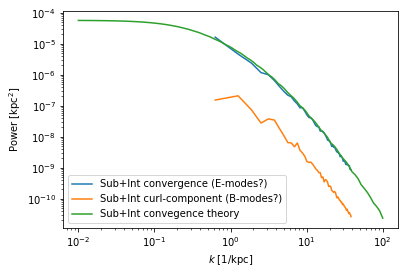

In [139]:
plt.loglog(emodes_k[emodes_k <= smallmax], emodes_p[emodes_k <= smallmax], label='Sub+Int convergence (E-modes?)')
plt.loglog(bmodes_k[bmodes_k <= smallmax], bmodes_p[bmodes_k <= smallmax], label='Sub+Int curl-component (B-modes?)')
#plt.loglog(subtheory_k[subtheory_k < 1e2], subtheory_p[subtheory_k < 1e2], label='Sub convergence theory')
plt.loglog(fulltheory_k, fulltheory_p, label='Sub+Int convegence theory')
plt.legend()
plt.xlabel(r'$k$ [1/kpc]')
plt.ylabel(r'Power [kpc$^2$]')

Text(0, 0.5, 'Power [kpc$^2$]')

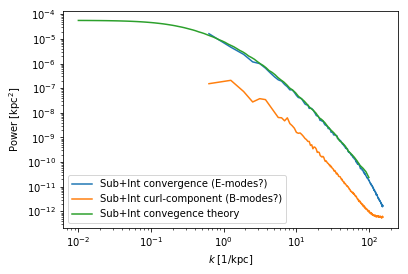

In [140]:
plt.loglog(emodes_k, emodes_p, label='Sub+Int convergence (E-modes?)')
plt.loglog(bmodes_k, bmodes_p, label='Sub+Int curl-component (B-modes?)')
#plt.loglog(subtheory_k[subtheory_k < 1e2], subtheory_p[subtheory_k < 1e2], label='Sub convergence theory')
plt.loglog(fulltheory_k, fulltheory_p, label='Sub+Int convegence theory')
plt.legend()
plt.xlabel(r'$k$ [1/kpc]')
plt.ylabel(r'Power [kpc$^2$]')

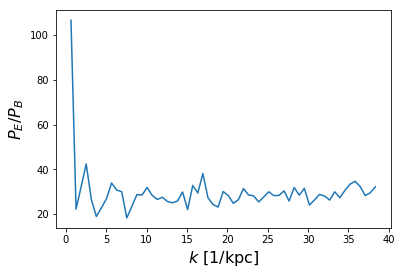

In [128]:
if np.max(abs(emodes_k - bmodes_k)) < .0001:
    plt.plot(emodes_k[emodes_k <= smallmax], emodes_p[emodes_k <= smallmax] / bmodes_p[emodes_k <= smallmax])
    plt.ylabel(r'$P_E / P_B$', size=16)
    plt.xlabel(r'$k$ [1/kpc]', size=16)

## No strong lens

In [9]:
ext = 0.8 # half-width of image in arcsec
pixnum = 500
pixsize = 2*ext/pixnum

In [10]:
weak_bmodes = np.load('files/curls_weak_ext0.8_pixnum500.npy')

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\times\\vec\\alpha$ (no strong lens)')

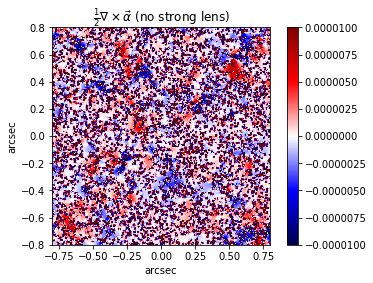

In [14]:
plt.imshow(weak_bmodes, extent=[-ext,ext,-ext,ext], vmin=-1e-5, vmax=1e-5, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\times\vec\alpha$ (no strong lens)')

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\times\\vec\\alpha$ (no strong lens)')

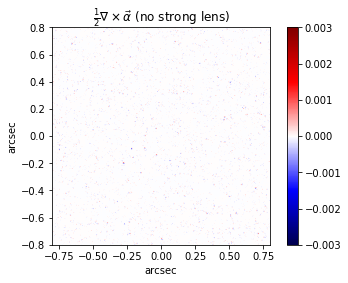

In [20]:
plt.imshow(weak_bmodes, extent=[-ext,ext,-ext,ext], vmin=-3e-3, vmax=3e-3, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\times\vec\alpha$ (no strong lens)')

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\cdot\\vec\\alpha$ (no strong lens)')

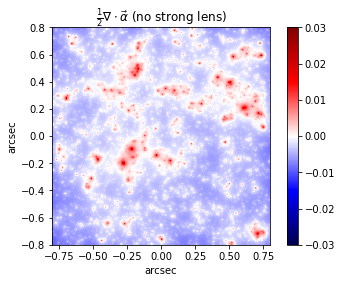

In [15]:
weak_emodes = np.load('files/kappa_weak_ext0.8_pixnum500.npy')
plt.imshow(weak_emodes, extent=[-ext,ext,-ext,ext], vmin=-.03, vmax=.03, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\cdot\vec\alpha$ (no strong lens)')

In [18]:
!~/python2 power_spectrum.py \
--conv_file1 files/curls_weak_ext0.8_pixnum500.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name weak_bmodes \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/curls_weak_ext0.8_pixnum500.npy
k saved in files/kweak_bmodes_095_496_10.txt
saved files/ind_curves_weak_bmodes_095_496_10.npy


In [17]:
!~/python2 power_spectrum.py \
--conv_file1 files/kappa_weak_ext0.8_pixnum500.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 10 \
--name weak_emodes \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/kappa_weak_ext0.8_pixnum500.npy
k saved in files/kweak_emodes_095_496_10.txt
saved files/ind_curves_weak_emodes_095_496_10.npy


In [25]:
weak_emodes_k = np.loadtxt('files/kweak_emodes_095_496_10.txt')
weak_emodes_p = np.load('files/ind_curves_weak_emodes_095_496_10.npy')[0]
weak_bmodes_k = np.loadtxt('files/kweak_bmodes_095_496_10.txt')
weak_bmodes_p = np.load('files/ind_curves_weak_bmodes_095_496_10.npy')[0]

Text(0.5, 1.0, 'No strong lens, but using $\\Sigma_{cr}$ and physical distances at $z_l = 0.2$')

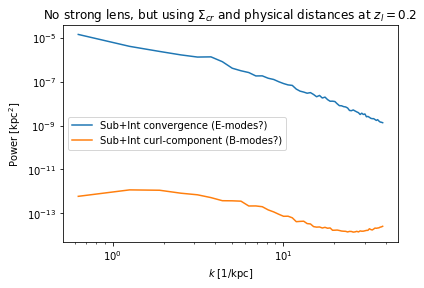

In [28]:
plt.loglog(weak_emodes_k[weak_emodes_k <= smallmax], weak_emodes_p[weak_emodes_k <= smallmax], label='Sub+Int convergence (E-modes?)')
plt.loglog(weak_bmodes_k[weak_bmodes_k <= smallmax], weak_bmodes_p[weak_bmodes_k <= smallmax], label='Sub+Int curl-component (B-modes?)')
#plt.loglog(subtheory_k[subtheory_k < 1e2], subtheory_p[subtheory_k < 1e2], label='Sub convergence theory')
#plt.loglog(fulltheory_k, fulltheory_p, label='Sub+Int convegence theory')
plt.legend()
plt.xlabel(r'$k$ [1/kpc]')
plt.ylabel(r'Power [kpc$^2$]')
plt.title(r'No strong lens, but using $\Sigma_{cr}$ and physical distances at $z_l = 0.2$')

---

## Full range

In [72]:
ext = 8.0 # half-width of image in arcsec
pixnum = 500
pixsize = 2*ext/pixnum

In [73]:
# recover alpha matrix from cannon output files
job_outs = ['cannon_out/myoutput_58385880.out']
linums = []
datalines = [None] * 500
for job_out in job_outs:
    with open(job_out, 'r') as f:
        for line in f:
            lin = line.split()
            if len(lin) > 4 and lin[0] == 'finished' and lin[1] == 'row':
                linum = int(lin[2])
                datalines[linum] = eval(' '.join(lin[3:]))
                linums.append(linum)
datalines = np.array(datalines)

In [74]:
datalines.shape

(500, 2, 500)

In [75]:
macro = np.load('files/alphasnew_macro_ext8.0_theta7.0.npy')

In [76]:
alphamat_x = datalines[:,0] - macro[0]
alphamat_y = datalines[:,1] - macro[1]

In [77]:
divmat, curlmat = recalc_div_curl_5pt(alphamat_x, alphamat_y)

emodes = 0.5*divmat
bmodes = 0.5*curlmat

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\times\\vec\\alpha$: full range')

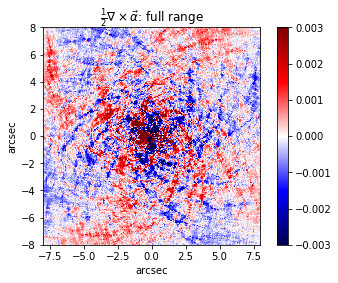

In [93]:
plt.imshow(bmodes, extent=[-ext,ext,-ext,ext], vmin=-.003, vmax=.003, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\times\vec\alpha$: full range')

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\cdot\\vec\\alpha$: full range')

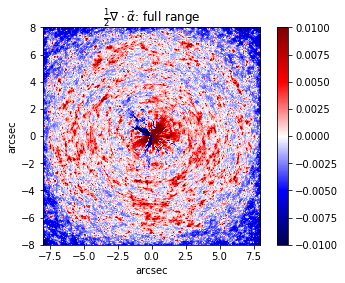

In [91]:
plt.imshow(emodes, extent=[-ext,ext,-ext,ext], vmin=-1e-2, vmax=1e-2, cmap='seismic')
plt.xlabel('arcsec'); plt.ylabel('arcsec')
plt.colorbar()
plt.title(r'$\frac{1}{2}\nabla\cdot\vec\alpha$: full range')

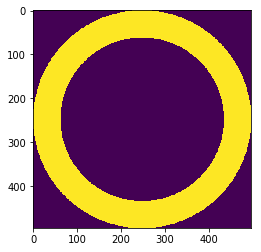

In [113]:
mymask = make_mask(1, 8.0, 500)
plt.imshow(mymask)

In [114]:
mask_coverage = np.sum(mymask) / (len(mymask)**2)

In [115]:
mask_coverage

0.34373374089490116

In [116]:
emodes_masked = emodes*mymask
for i in range(len(emodes_masked)):
    for j in range(len(emodes_masked)):
        if emodes_masked[i,j] == 0:
            emodes_masked[i,j] = float('nan')

In [117]:
np.save('files/tmp_emodes_masked.npy', emodes*mymask)
np.save('files/tmp_bmodes_masked.npy', bmodes*mymask)

In [118]:
!~/python2 power_spectrum.py \
--conv_file1 files/tmp_emodes_masked.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 101 \
--name emodes2 \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/tmp_emodes_masked.npy
k saved in files/kemodes2_095_496_101.txt
saved files/ind_curves_emodes2_095_496_101.npy


In [119]:
!~/python2 power_spectrum.py \
--conv_file1 files/tmp_bmodes_masked.npy \
--kdir files/ \
--psdir files/ \
--pix_num 496 \
--side 101 \
--name bmodes2 \
--num_proj 1 \
--sigma_crit 3.01e9

convergence maps loaded:
files/tmp_bmodes_masked.npy
k saved in files/kbmodes2_095_496_101.txt
saved files/ind_curves_bmodes2_095_496_101.npy


In [146]:
emodes2_k = np.loadtxt('files/kemodes2_095_496_101.txt')
emodes2_p = np.load('files/ind_curves_emodes2_095_496_101.npy')[0] / mask_coverage # not yet normalized
bmodes2_k = np.loadtxt('files/kbmodes2_095_496_101.txt')
bmodes2_p = np.load('files/ind_curves_bmodes2_095_496_101.npy')[0] / mask_coverage # not yet normalized

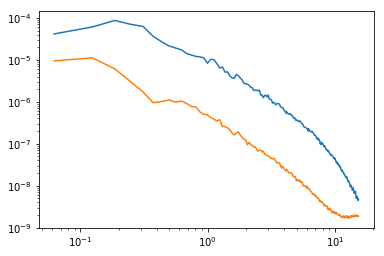

In [147]:
plt.loglog(emodes2_k, emodes2_p)
plt.loglog(bmodes2_k, bmodes2_p)

## Combined results

In [144]:
bigmin = 2*np.pi/101 * 4 # mask width
bigmax = 2*np.pi/(2/496*101) / 4 # Nyquist/stencil
smallmax = 2*np.pi/(2/496*10.1) / 4 # Nyquist/stencil

## make array filters
smallfilter = emodes_k <= smallmax
bigfilter = (bigmin <= emodes2_k) * (emodes2_k <= bigmax)

Text(0, 0.5, 'Power [kpc$^2$]')

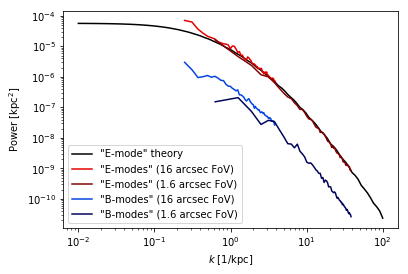

In [158]:
plt.loglog(fulltheory_k, fulltheory_p, label='"E-mode" theory', color='black')

plt.loglog(emodes2_k[bigfilter], emodes2_p[bigfilter], label='"E-modes" (16 arcsec FoV)', color='xkcd:red')
plt.loglog(emodes_k[smallfilter], emodes_p[smallfilter], label='"E-modes" (1.6 arcsec FoV)', color='xkcd:dark red')

plt.loglog(bmodes2_k[bigfilter], bmodes2_p[bigfilter], label='"B-modes" (16 arcsec FoV)', color='xkcd:blue')
plt.loglog(bmodes_k[smallfilter], bmodes_p[smallfilter], label='"B-modes" (1.6 arcsec FoV)', color='xkcd:dark blue')

plt.legend()
plt.xlabel(r'$k$ [1/kpc]')
plt.ylabel(r'Power [kpc$^2$]')

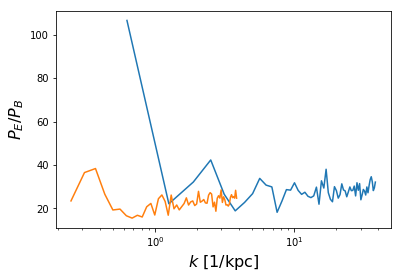

In [168]:
plt.plot(emodes_k[smallfilter], emodes_p[smallfilter] / bmodes_p[smallfilter])
plt.plot(emodes2_k[bigfilter], emodes2_p[bigfilter] / bmodes2_p[bigfilter])
plt.ylabel(r'$P_E / P_B$', size=16)
plt.xlabel(r'$k$ [1/kpc]', size=16)
plt.gca().set_xscale('log')

## Toy simulation results

Mass $10^8 \, M_\odot$, $z_i=0.2$ and $z_i=0.8$. How do the curl fields look?

In [201]:
ext = 8.0

In [202]:
curl02 = np.load('files/toy_curl_z0.2.npy')
curl08 = np.load('files/toy_curl_z0.8.npy')

Text(0.5, 1.0, 'Simulation (fg): $z_i = 0.2$, $z_l = 0.5$')

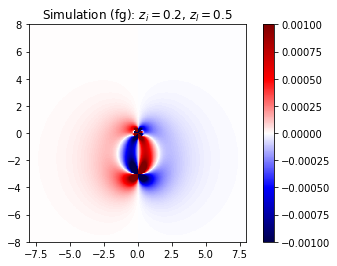

In [207]:
plt.imshow(curl02, extent=[-ext,ext,-ext,ext], vmin=-.001, vmax=.001, cmap='seismic')
plt.colorbar()
plt.title(r'Simulation (fg): $z_i = 0.2$, $z_l = 0.5$')

Text(0.5, 1.0, 'Simulation (bg): $z_i = 0.8$, $z_l = 0.5$')

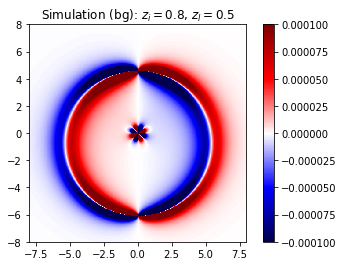

In [208]:
plt.imshow(curl08, extent=[-ext,ext,-ext,ext], vmin=-.0001, vmax=.0001, cmap='seismic')
plt.colorbar()
plt.title(r'Simulation (bg): $z_i = 0.8$, $z_l = 0.5$')